## This notebook is intended to generate some statistics on the snowfall datasets

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

**Read in processsed meteorological data**

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)


asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)







In [3]:

all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')


count    338.000000
mean       4.612071
std        2.126234
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


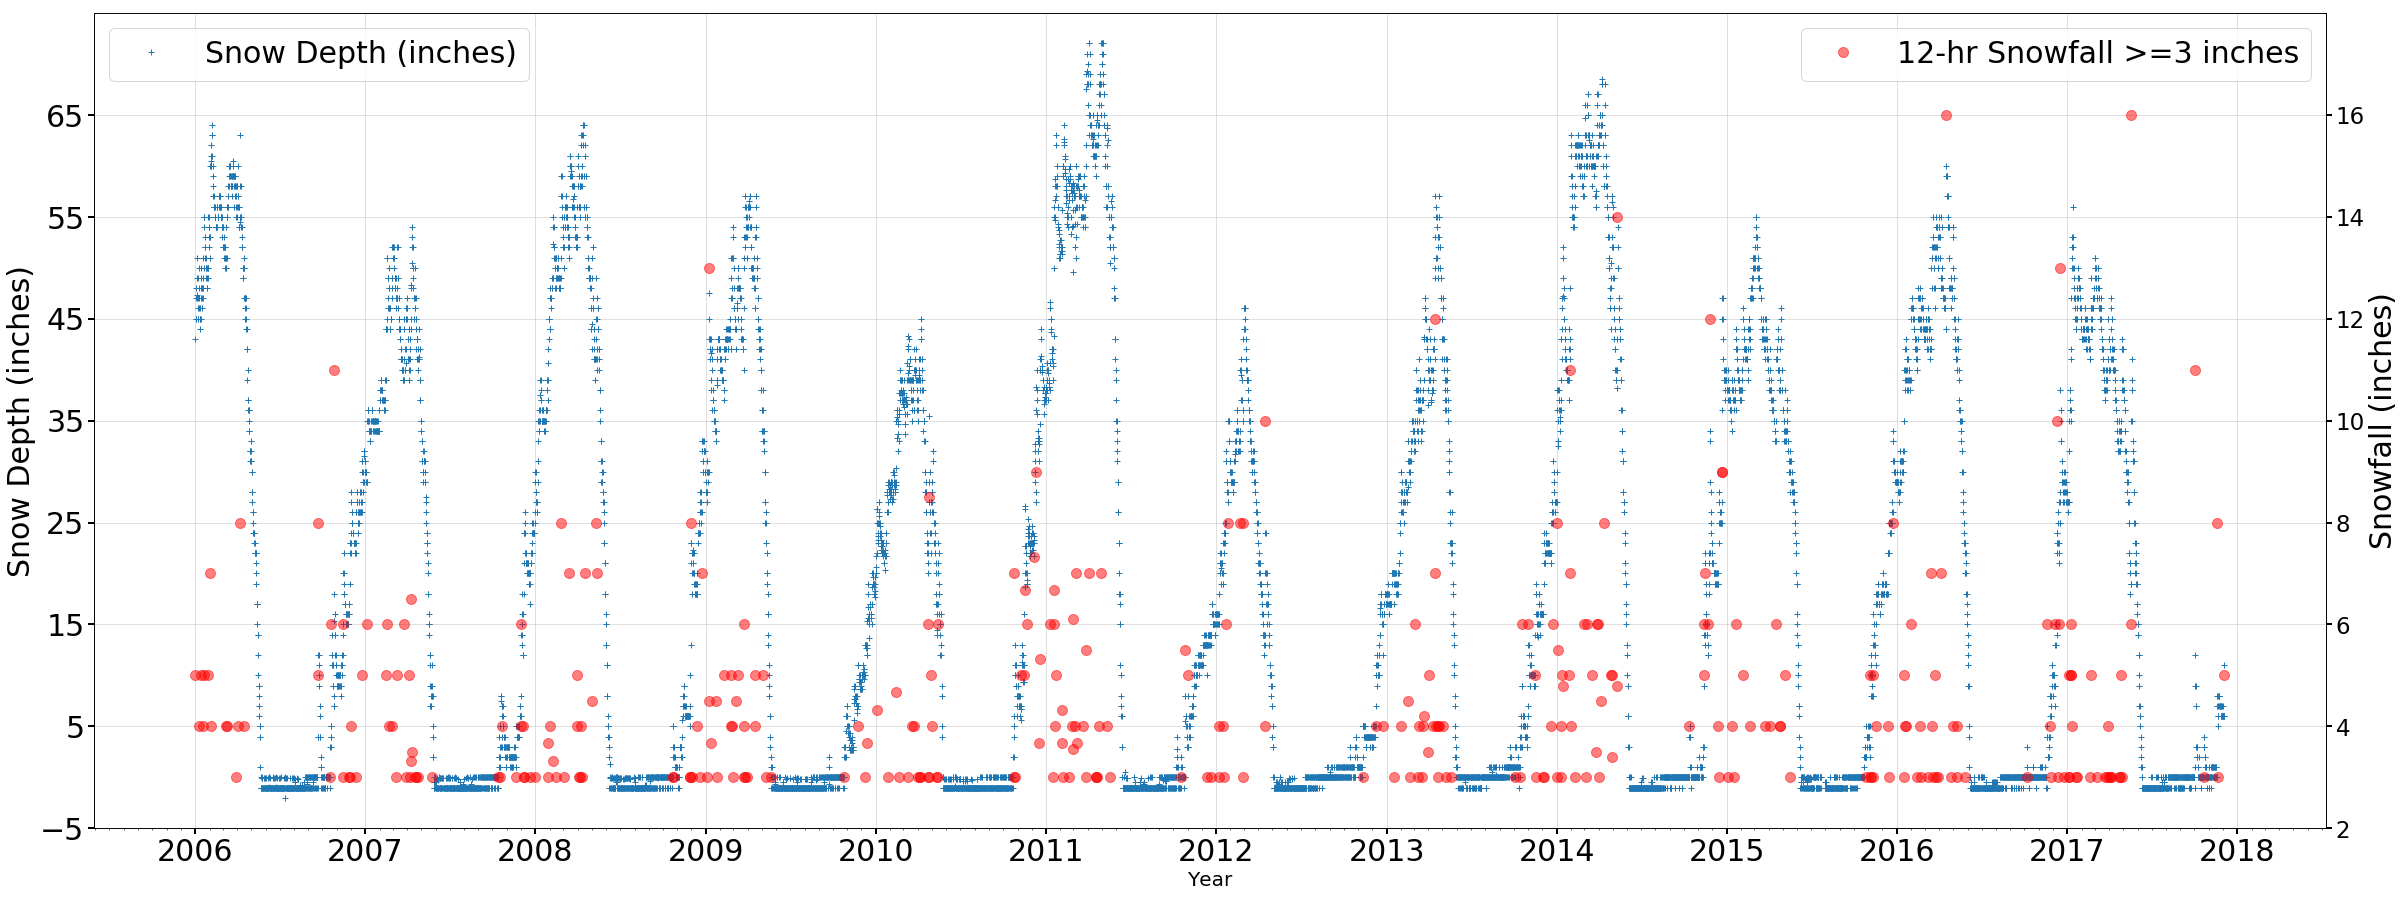

In [4]:

import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(40,15))
ax2 = ax1.twinx()
#ax1.plot(asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10, label = "1hr Snow Depth")

ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][all_yrs], marker='+', markersize = 6, linestyle = 'None', label = "Snow Depth (inches)")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][all_yrs], marker='.', linestyle = 'None', markersize = 20, alpha = 0.5,  label = "12-hr Snowfall >=3 inches" , color = 'r')

ax2.set_yticks(np.arange(2,18,2))
ax1.set_yticks(np.arange(-5,75,10))
#ax2.set_yticks([2,4,6,7,8,9,10,11,12,13,14,15,16,17,18])
#ax1.set_yticks([-5,5, 15,25,35,45,55,65,75])

numsteps = 9
#ax2.set_yticks(np.linspace(ax2.yaxis.min(),ax2.yaxis.max(),numStep))
#ax1.set_yticks(np.linspace(ylim()[0],ylim()[1],numSteps))

ax1.set_ylim(-5,75)
ax2.set_ylim(2,18)

ax1.grid(True)


ax1.legend(loc='upper left', fontsize = 30)
ax2.legend(loc='upper right', fontsize = 30)

ax1.set_ylabel('Snow Depth (inches)', size = 30)
ax2.set_ylabel('Snowfall (inches)', size = 30)

ax1.set_xlabel('Year', size=20)
ax1.tick_params(direction='out', length=6, width=2, grid_alpha=0.5, labelsize=30)

ax2.tick_params(direction='out', length=6, width=2, grid_alpha=0.5, labelsize=23)

ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_locator(mdates.YearLocator())

#ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # hours and minutes
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d-%Y')) 


print(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())
fig.savefig(r'C:\Users\RAPP\Documents\Capstone\Report\figs\snowdepth_snowfall.png', bbox_inches='tight')

**It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.**

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

**Define all surface and upper air data features of interest**

In [5]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']






**Now loop through each feature, finding features which have >67% data capture throughout period.  **Because we will want an apples to apples type comparision with the OLS model we perform with Surface+UA data, we must be sure sure to use the same snowfall data. **For every snowfall amount used, there must be a datapoint for every corresponding surface and upper air data features.  Therefore, any rows with an NaN value will be removed from the analysis.**

In [6]:
good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    


Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

**For future analyses, we should take note of these features...**

* **The list of surface features with high data capture are:**  
    **['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']**  
   
   

* **The list of upper air data features with high data capture are:**  
     **['KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']**

**We only want to use snowfall events which have a concurrent meteorological measurement for all the features.  Create new dataframe with just this data:**

In [7]:
good_vars_snf =[]


good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']


test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()

#print(asos_snotel_UA_df[good_vars_snf] ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2014'].describe())
print(test_train_df.info())

print('The total number of snowfall events is: ' + str(len(test_train_df)))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2006-01-01 12:00:00+00:00 to 2017-12-04 00:00:00+00:00
Columns: 124 entries, CMtnSNTL_Temp_degC to CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in
dtypes: float64(124)
memory usage: 249.0 KB
None
The total number of snowfall events is: 255


**Looks like 255 snowfall events total.**
**Write this to file for use when performing OLS modeling:** 

In [8]:
test_train_df.to_csv('test_train_df.dat',sep = ',', float_format = '%.2f')

### Snowfall Statistics by Year and Test/Train Set

**Define some indicies which will help separate out test/train datasets**

In [9]:

##Before filtering
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
test_yrs_A=  (asos_snotel_UA_df.index >= '01-01-2015')
train_yrs_A = (asos_snotel_UA_df.index>= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2015')

train_yrs_B = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2013')) | ((asos_snotel_UA_df.index >= '01-01-2015') & (asos_snotel_UA_df.index < '01-01-2018'))
test_yrs_B = (asos_snotel_UA_df.index >= '01-01-2013') & (asos_snotel_UA_df.index < '01-01-2015')


##After filtering
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
test_yrs_tt_A=  (test_train_df.index >= '01-01-2015') 
train_yrs_tt_A = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2015')

train_yrs_tt_B = ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2013')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt_B = (test_train_df.index >= '01-01-2013') & (test_train_df.index < '01-01-2015')

**Now create a dictionary of snowfall event stats by year and test/train set**

In [10]:
import statistics as sts



from tabulate import tabulate
years_tt = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B]
year_lbls = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', 'All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',]
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', all_yrs, train_yrs_A, train_yrs_B, test_yrs_A, test_yrs_B]


counts, means, maxes, sd_missings, std_devs, medians, possible_snf, data2plot = [], [], [], [], [], [], [], []


for year in years_tt:


    counts.append(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].count())
    maxes.append((round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].max(),1)))
    means.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].mean(),1))
    medians.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].median(),1))
    
    #sd_missings.append(round(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count()/len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year][idx])/12*100,2))
    std_devs.append(round(np.std(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].dropna()),2))
    #print(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count(),len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year])/12)
    data2plot.append(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].values.tolist())
   
    
    
#Calculate potential snowfalls
for year in years:
    possible_snf.append(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].count())
    
    
tbl = zip(year_lbls, counts, possible_snf, means, medians, maxes,std_devs )  




**Make a table**

In [11]:
print('Snowfall Event Statistics by Year and Test/Train Set')
print(tabulate(tbl, headers=['Year', '# of Events with Met', "Poss # of Events", 'Mean', 'Median','Max',  'Std Deviation'], tablefmt='github'))

Snowfall Event Statistics by Year and Test/Train Set
| Year           |   # of Events with Met |   Poss # of Events |   Mean |   Median |   Max |   Std Deviation |
|----------------|------------------------|--------------------|--------|----------|-------|-----------------|
| 2006           |                     21 |                 26 |    5   |      5   |  11   |            2.05 |
| 2007           |                     23 |                 29 |    3.9 |      3.3 |   6.5 |            1.18 |
| 2008           |                     25 |                 27 |    4.3 |      3.3 |   8   |            1.84 |
| 2009           |                     16 |                 27 |    3.9 |      3.8 |   6   |            0.87 |
| 2010           |                     20 |                 30 |    4.4 |      3.8 |   9   |            1.77 |
| 2011           |                     23 |                 32 |    4.3 |      4   |   7   |            1.33 |
| 2012           |                      5 |                

**We can see in the "# of Evens with Met" column that the test/train sets chosen do represent an approximately 20/80 test/train set split and ae similarly sized.**

count    338.000000
mean       4.612071
std        2.126234
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


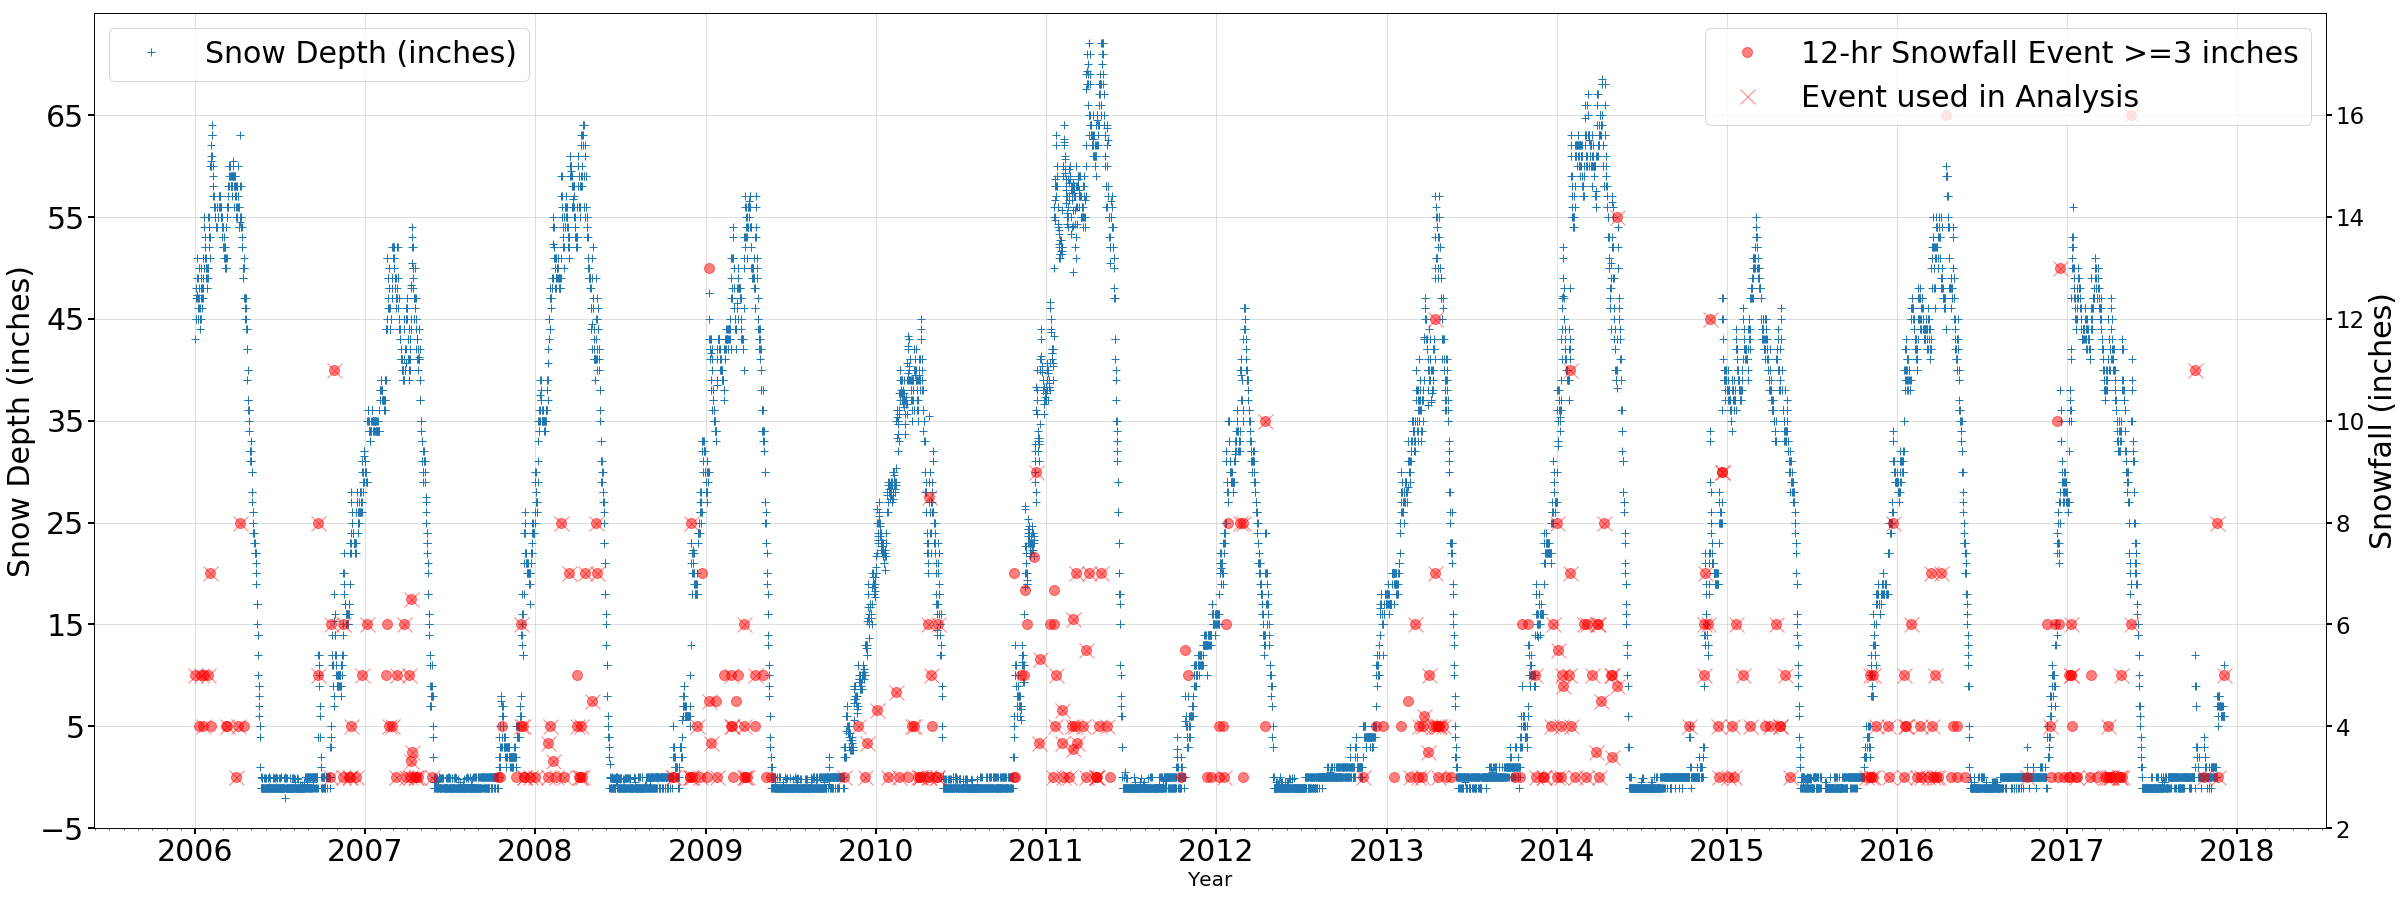

In [12]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(40,15))
ax2 = ax1.twinx()

#ax1.plot(asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10, label = "1hr Snow Depth")

ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][all_yrs], marker='+', markersize = 8, linestyle = 'None', label = "Snow Depth (inches)")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][all_yrs], marker='.', linestyle = 'None', markersize = 20, alpha = 0.5,  label = "12-hr Snowfall Event >=3 inches" , color = 'r')

 
ax2.plot(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][all_yrs_tt], marker='x', linestyle = 'None', markersize = 15, alpha = 0.5,  label = "Event used in Analysis" , color = 'r')

ax2.set_yticks(np.arange(2,18,2))
ax1.set_yticks(np.arange(-5,75,10))
#ax2.set_yticks([2,4,6,7,8,9,10,11,12,13,14,15,16,17,18])
#ax1.set_yticks([-5,5, 15,25,35,45,55,65,75])

numsteps = 9
#ax2.set_yticks(np.linspace(ax2.yaxis.min(),ax2.yaxis.max(),numStep))
#ax1.set_yticks(np.linspace(ylim()[0],ylim()[1],numSteps))

ax1.set_ylim(-5,75)
ax2.set_ylim(2,18)

ax1.grid(True)


ax1.legend(loc='upper left', fontsize = 30)
ax2.legend(loc='upper right', fontsize = 30)

ax1.set_ylabel('Snow Depth (inches)', size = 30)
ax2.set_ylabel('Snowfall (inches)', size = 30)

ax1.set_xlabel('Year', size=20)
ax1.tick_params(direction='out', length=6, width=2, grid_alpha=0.5, labelsize=30)

ax2.tick_params(direction='out', length=6, width=2, grid_alpha=0.5, labelsize=23)

ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_locator(mdates.YearLocator())

#ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # hours and minutes
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d-%Y')) 


print(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())
fig.savefig(r'C:\Users\RAPP\Documents\Capstone\Report\figs\snowdepth_snowfall.png', bbox_inches='tight')

**Make a box and whisker plot as well.**

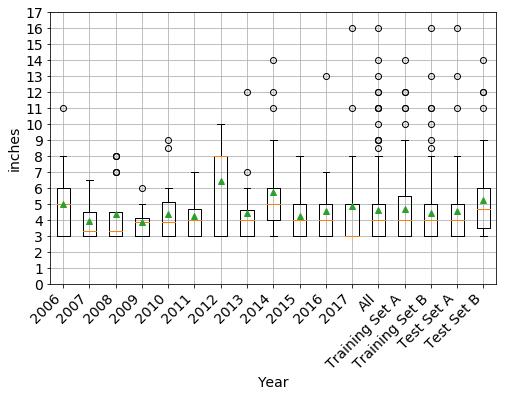

In [13]:
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)

plt.boxplot(data2plot, showmeans=True)  
#plt.title('Box Plot of ' + keys[k])
ax.set_xticklabels(year_lbls, rotation = 45, fontsize = 14, ha = 'right')

v = list(np.arange(0,18,1))

ax.set_yticks(v)
ax.set_yticklabels(v, fontsize = 14)
ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('inches', fontsize = 14)
#ax.set_ylabel(keys[k])





plt.grid(True)

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/model_snowfall.png', bbox_inches='tight')


**This just verifies that the test/train sets each capture some higher snowfall events**

## Snowfall Distributions of Test/Train Sets

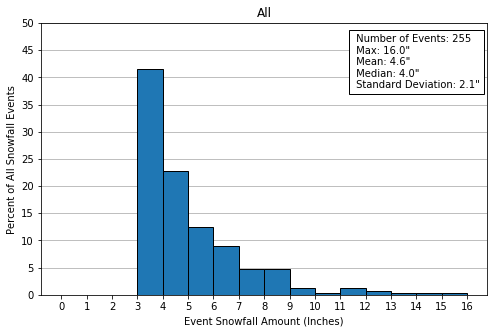

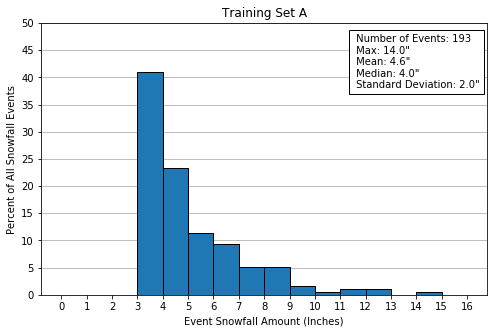

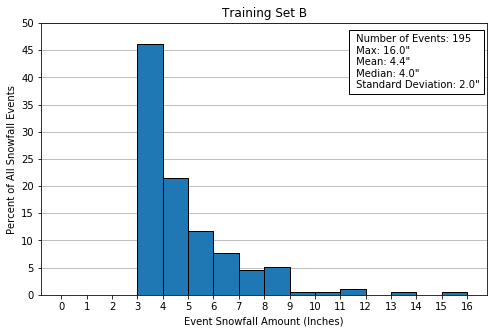

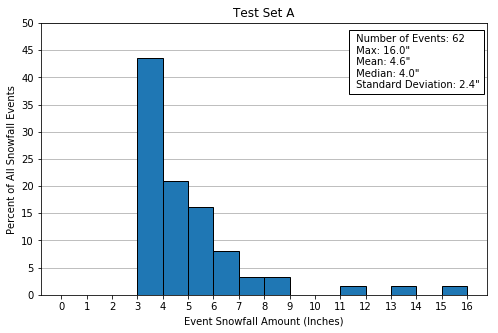

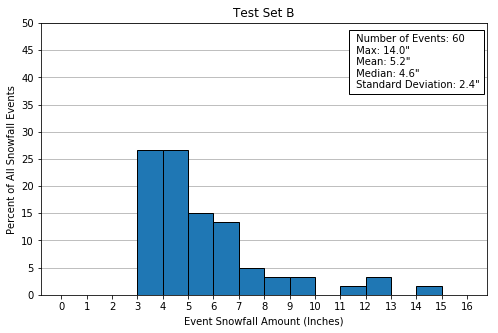

In [15]:
df = pd.DataFrame()
df = pd.DataFrame(list(zip(year_lbls, counts, possible_snf, means, medians, maxes,std_devs))  , columns = ['year_lbls', 'counts', 'possible_snf', 'means', 'medians', 'maxes','std_devs'])

df.set_index('year_lbls', inplace = True)

year_dict = dict(zip(['All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',], [all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B])) 

for year_lbl in year_dict.keys():

  fig = plt.figure(figsize=(8,5))
  ax = plt.subplot(1,1,1)
  weights = np.ones_like(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year_dict[year_lbl]])/float(len(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year_dict[year_lbl]]))

  
  plt.hist(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year_dict[year_lbl]], histtype = 'bar', weights=weights*100, \
           bins = np.arange(0,17,1), align = 'mid', edgecolor = 'black') 
  plt.annotate(' Number of Events: ' + str(round(df['counts'][year_lbl],0)) +  \
               '\n Max: ' + str(round(df['maxes'][year_lbl],1)) + '"' + \
               '\n Mean: ' + str(round(df['means'][year_lbl],1)) + '"' + \
               '\n Median: ' + str(round(df['medians'][year_lbl],1))+ '"' + \
               '\n Standard Deviation: ' + str(round(df['std_devs'][year_lbl],1))+ '"' , \
                 xy=(0.70, 0.76), xycoords='axes fraction', fontsize=10, \
                 bbox=dict(facecolor='white', edgecolor='black'))




  plt.xticks(np.arange(0,17,1))
  plt.ylabel('Percent of All Snowfall Events')
  plt.xlabel('Event Snowfall Amount (Inches)' )
  plt.ylim(0,50)
  plt.yticks(np.arange(0,55,5))
  ax.set_axisbelow(True)
  plt.grid(True, axis = 'y')

  plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/snowfall_histogram_'+ str(year_lbl) + '.png', bbox_inches='tight')

  plt.title(year_lbl)
  plt.show()
#ax.set_yticklabels(np.arange(0,50,10), fontsize = 14)

**We can see that while the test/train sets in Partition A have similar distributions, the test/train sets for Partition B are different.  The Partition B test set seems to have a higher number of larger snowfall events.  
These histograms do make it apparent that the distributions are indeed heavily weighted by lighter snowfall events**